## Import libraries and all standard stuff

In [ ]:
!pip install keras_cv
!pip install keras==3.4.1
!pip install tensorflow==2.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenges

Mounted at /gdrive
/gdrive/My Drive/Challenges


In [ ]:
# Set seed for reproducibility
seed = 69

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print("TensorFlow and Keras versions:")
print(tf.__version__)
print(tfk.__version__)

# Import other libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

TensorFlow and Keras versions:
2.17.0
3.4.1


## Load and inspect data

In [ ]:
dataset = np.load('Datasets/training_set.npz')
X = dataset['images']
y = dataset['labels']

Now we check the content of the dataset :

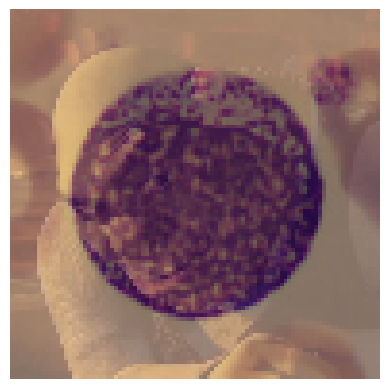

In [ ]:

plt.imshow(np.squeeze(X[13130]), vmin=0., vmax=1.)
plt.axis('off')
plt.show()

# Or to save it as a file (e.g., as a PNG)
plt.imsave("X_13130.png", np.squeeze(X[13130]), vmin=0., vmax=1.)

There are images with a background that could lead to a wrong classifier. Moreover, there are a lot of duplicates, mainly of two types : the ones with a shrek background and the ones with a Rick Roll background.

In [ ]:
# # Shit there are duplicates, let's remove them

seen = {}
duplicate_idx = set()

for i, x in enumerate(X):
    # Use the byte representation of the array as a hashable key
    x_bytes = x.tobytes()
    if x_bytes in seen:
        # If already seen, add both the current index and the original index to idx
        duplicate_idx.add(seen[x_bytes])  # Original index where the duplicate was first seen
        duplicate_idx.add(i)              # Current index of the duplicate
    else:
        # Store the first occurrence of each unique array by its byte representation
        seen[x_bytes] = i

# Print the results
print("There are", len(duplicate_idx), " duplicates")

There are 1816  duplicates


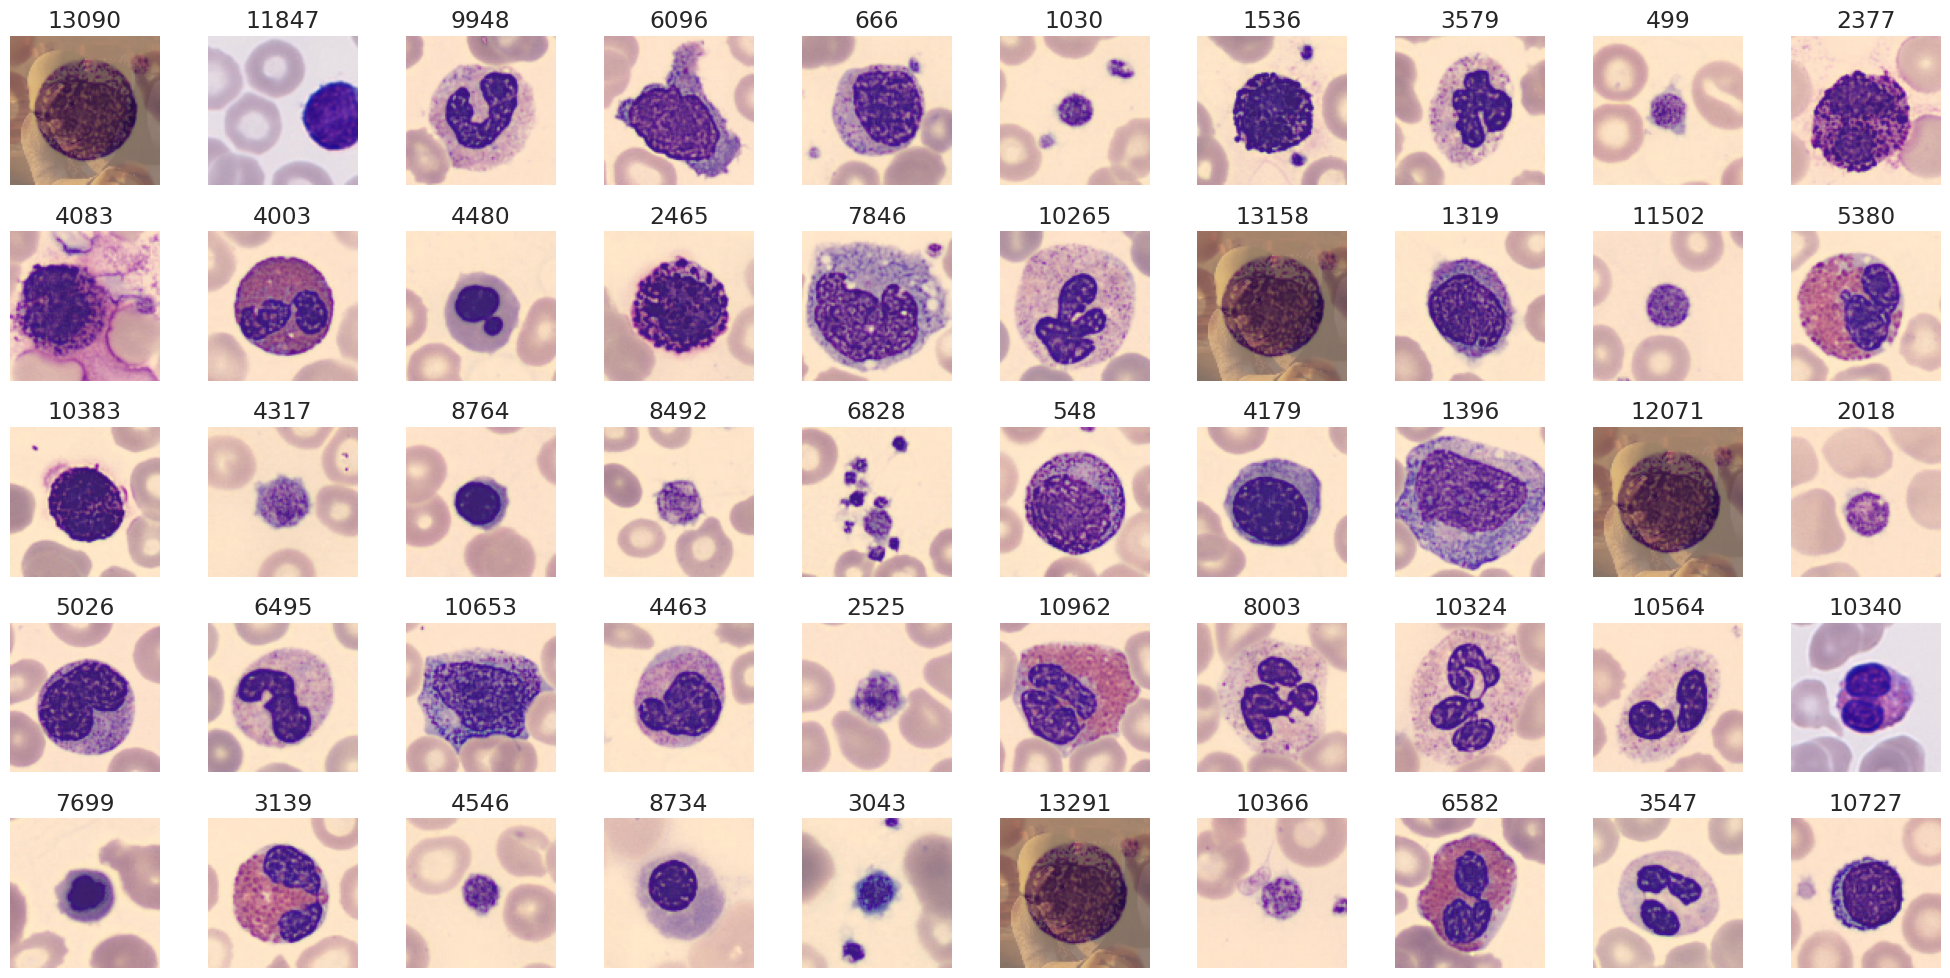

In [ ]:
# Number of images to display
num_img = 50
random_idx = random.sample(range(0, len(X)), num_img)

# Create a 5x10 grid for subplots (5 rows and 10 columns)
fig, axes = plt.subplots(5, 10, figsize=(20, 10))

# Iterate through the selected number of images
for i, index_to_find in enumerate(random_idx):
    row = i // 10  # Determine the row index
    col = i % 10   # Determine the column index
    ax = axes[row, col]
    ax.imshow(np.squeeze(X[index_to_find]), vmin=0., vmax=1.)
    ax.set_title(f'{index_to_find}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()


In [ ]:
duplicate_idx = list(duplicate_idx)
mask = np.ones(len(X), dtype=bool)
mask[duplicate_idx] = False
X_cleaned = X[mask]
y_cleaned = y[mask]

Now that we have cleaned our dataset, we can save it in order to avoid these inspections at each run.

In [ ]:

cleaned_dataset = {
    'images': X_cleaned,
    'labels': y_cleaned
}

np.savez("cleaned_training_set.npz", images=X_cleaned, labels=y_cleaned)

Let's see the class balancing :

In [ ]:
# Create the histogram
plt.hist(y, bins=30, edgecolor='black', alpha=0.7)

# Add title and labels
plt.title('Distribuition of classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Show the plot
plt.show()

SyntaxError: '(' was never closed (<ipython-input-12-3af6045b60e6>, line 7)

As we can see, there are some classes unbalanced; to overcome this problem, we could perform upsampling or class weights. After some tests, the best way was using class weights :

In [ ]:
total = 11943
n_classes = 8.0

weight_for_s0 = (1 / 848) * (total / n_classes)
weight_for_s1 = (1 / 2177) * (total / n_classes)
weight_for_s2 = (1 / 1085) * (total / n_classes)
weight_for_s3 = (1 / 2020) * (total / n_classes)
weight_for_s4 = (1 / 849) * (total / n_classes)
weight_for_s5 = (1 / 991) * (total / n_classes)
weight_for_s6 = (1 / 2330) * (total / n_classes)
weight_for_s7 = (1 / 1643) * (total / n_classes)


class_weight = {0: weight_for_s0, 1: weight_for_s1, 2: weight_for_s2, 3: weight_for_s3,
                4: weight_for_s4, 5: weight_for_s5, 6: weight_for_s6, 7: weight_for_s7}

print('Weight for class 1: {:.2f}'.format(weight_for_s0))
print('Weight for class 2: {:.2f}'.format(weight_for_s1))
print('Weight for class 3: {:.2f}'.format(weight_for_s2))
print('Weight for class 4: {:.2f}'.format(weight_for_s3))
print('Weight for class 5: {:.2f}'.format(weight_for_s4))
print('Weight for class 6: {:.2f}'.format(weight_for_s5))
print('Weight for class 7: {:.2f}'.format(weight_for_s6))
print('Weight for class 8: {:.2f}'.format(weight_for_s7))

## Pre-processing: image augmentation, normalization, rescaling.


We tested different layers of keras_cv, based on both the performance obtained on codabench and the utility of applying a certain type of layer. Some pipelines could not be tested.

In [ ]:
## Augmentation
import keras_cv

# Augmentation used in the scratch CNN
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    # tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='augmentation')

augmentation_pipeline = tf.keras.Sequential([

    tfkl.RandomRotation(0.4, value_range=([0,255])),
    tfkl.RandomTranslation(0.4,0.4),
    tfkl.RandomBrightness(0.7,  value_range=([0,255])),
    tfkl.RandomContrast(0.8),

    keras_cv.layers.ChannelShuffle(),
    keras_cv.layers.RandomFlip("horizontal_and_vertical"),
    keras_cv.layers.RandomCutout(0.3, 0.3),
    # 0.77 score on codabench using all the aboves

    keras_cv.layers.RandomSaturation(0.5),
    keras_cv.layers.RandomColorDegeneration(0.5)
    #0.79 score on codabench using all the aboves

])

augmentation_pipeline_not_tested = tf.keras.Sequential([
    keras_cv.layers.ChannelShuffle(),
    keras_cv.layers.RandomFlip("horizontal_and_vertical"),
    keras_cv.layers.RandomCutout(0.4, 0.4),

    keras_cv.layers.RandomSaturation(0.5),

    tf.keras.layers.GaussianNoise(stddev=1),

    keras_cv.layers.AugMix(value_range =[0,255], severity=0.5, num_chains=4, chain_depth=[1, 3], alpha=1.0),
    keras_cv.layers.RandAugment(value_range=[0,255], rate = 10/11)
])

For normalization and rescaling, since most of the models that we used had its own pre-processing function, we called it before passing the data to our model. Moreover, the rescaling has been applied as a layer directly into our model.

Only our CNN from scratch needed a dedicated preprocessing:

##### CNN from Scratch - **preprocessing**

In [ ]:
# # Processing of data
def scratchCNNpreprocess(X_tr, X_v):
  X_tr = (X_tr / 255.).astype(np.float32)
  X_v = (X_v / 255.).astype(np.float32)
  return X_tr, X_v

## Train - validation split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed,
    stratify=y
)

# Print the shapes of the resulting sets
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)

In [ ]:
# One-hot encoding of targets
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

## Utils functions
In particular, we can define here the function to plot the heatmap of some dataset, given a certain model.

In [ ]:
def printHeatmap(model_totest, X_totest, y_totest):
  # Predict class probabilities and get predicted classes
  train_predictions = model_totest.predict(X_totest, verbose=0)
  train_predictions = np.argmax(train_predictions, axis=-1)

  # Extract ground truth classes
  train_gt = np.argmax(y_totest, axis=-1)

  # Calculate and display training set accuracy
  train_accuracy = accuracy_score(train_gt, train_predictions)
  print(f'Accuracy score over the train set: {round(train_accuracy, 4)}')

  # Calculate and display training set precision
  train_precision = precision_score(train_gt, train_predictions, average='weighted')
  print(f'Precision score over the train set: {round(train_precision, 4)}')

  # Calculate and display training set recall
  train_recall = recall_score(train_gt, train_predictions, average='weighted')
  print(f'Recall score over the train set: {round(train_recall, 4)}')

  # Calculate and display training set F1 score
  train_f1 = f1_score(train_gt, train_predictions, average='weighted')
  print(f'F1 score over the train set: {round(train_f1, 4)}')

  # Compute the confusion matrix
  cm = confusion_matrix(train_gt, train_predictions)

  # Create labels combining confusion matrix values
  labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

  # Plot the confusion matrix with class labels
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=labels, fmt='',   cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()


In [ ]:
def plotTrValInfo(history_toplot):
  # Create a figure with two vertically stacked subplots
  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)

  # Plot training and validation loss
  ax1.plot(history_toplot['loss'], label='Training loss', alpha=.8)
  ax1.plot(history_toplot['val_loss'], label='Validation loss', alpha=.8)
  ax1.set_title('Loss')
  ax1.legend()
  ax1.grid(alpha=.3)

  # Plot training and validation accuracy
  ax2.plot(history_toplot['accuracy'], label='Training accuracy', alpha=.8)
  ax2.plot(history_toplot['val_accuracy'], label='Validation accuracy', alpha=.8)
  ax2.set_title('Accuracy')
  ax2.legend()
  ax2.grid(alpha=.3)

  # Adjust the layout and display the plot
  plt.tight_layout()
  plt.subplots_adjust(right=0.85)
  plt.show()


# Build the model

### Network Parameters

In [ ]:
epochs = 200
batch_size = 128
learning_rate = .001


In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

### CNN from Scratch - baseline

In [ ]:
def build_model_scratchCNN(
    input_shape = input_shape,
    output_shape = output_shape,
    learning_rate = learning_rate,
    seed = seed,
    augmentation = None
):
  tf.random.set_seed(seed)

  # Build the neural network layer by layer
  inputs = tfkl.Input(shape=input_shape, name='Input')

  # Apply optional data augmentation, then first convolutional layer
  if augmentation == None:
      x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(inputs)
  else:
      x = augmentation(inputs)
      x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)

  x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(x)
  x = tfkl.Activation('relu', name='act1')(x)
  x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

  x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
  x = tfkl.Activation('relu', name='act2')(x)
  x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

  x = tfkl.Flatten(name='flatten')(x)

  x = tfkl.Dense(units=output_shape, name='dense')(x)
  outputs = tfkl.Activation('softmax', name='softmax')(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

  # Compile the model
  loss = tfk.losses.CategoricalCrossentropy()
  optimizer = tfk.optimizers.Adam(learning_rate)
  metrics = ['accuracy']
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  # Return the model
  return model

In [ ]:
model = build_model_scratchCNN(augmentation=True)
model.summary(expand_nested = True, show_trainable = True)
tfk.utils.plot_model(model, expand_nested = True, show_trainable = True, show_shapes = True, dpi = 70)

#Training

Here we define the Early Stopping callback, that will be used for all our models.

In [ ]:
# Define the patience value for early stopping
patience = 50

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

### CNN from scratch - baseline

In [ ]:

X_train, X_val = scratchCNNpreprocess(X_train, X_val)

# Store the callback in a list
callbacks = [early_stopping]

# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')


model.save("model_try_pontig.keras")
del model

In [ ]:
model = tfk.models.load_model("model_try_pontig.keras")
model.summary()

In [ ]:
plotTrValInfo(history)

In [ ]:
printHeatmap(model, X_train, y_train)
printHeatmap(model, X_val, y_val)